<a href="https://colab.research.google.com/github/rachel1818/Recommender/blob/main/Colab_Code_G17Project_07April2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING OF LIBRARIES**

In [ ]:
%pip install surprise
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import Reader, Dataset, SVD, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise import accuracy
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from scipy import sparse
from scipy.sparse import csr_matrix as csr
import warnings; warnings.simplefilter('ignore')
import nltk
nltk.download('wordnet')

     |████████████████████████████████| 6.5MB 3.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678589 sha256=bd0a1b5092f33daaa0a7d8a69e5ad0b802a377cc30b3ca61dcda8e78e2c4f339
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

***PREVIEWING OF THE DATASET***

In [ ]:
movies = pd.read_csv('movies_metadata.csv')
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
ratings_n = pd.read_csv('ratings_small.csv')

In [ ]:
ratings_n.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


***PROCESSING*** 

***USING literal_eval TO SAFELY EVALUATE STRINGS IN THE GENRE COLUMN***

In [ ]:
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


***READING THE LINKS FILE***

In [ ]:
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

***DROPPED ROWS WHICH WEREN'T USEFUL TO THE DATA PROCESSING***

In [ ]:
movies = movies.drop([19730, 29503, 35587])

In [ ]:
movies['id'] = movies['id'].astype('int')

***SELECTING THE MOVIES WHICH ARE PRESENT IN THE LINKS_SMALL FILE***

In [ ]:
movies_links = movies[movies['id'].isin(links_small)]
movies_links.shape

(9099, 25)

In [ ]:
movies_links["movieId"] = movies_links["id"]

### ***MOVIE RECOMMENDATION USING CLUSTERRING ALGORITHM (KNN)***

***MERGING THE RATING AND MOVIES TABLE***

In [ ]:
ratings_title = pd.merge(ratings_n, movies_links[['movieId', 'original_title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'original_title', values='rating')

In [ ]:
# Dispaying the dimensions of the dataset and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (671, 1536) 

Subset example:


original_title,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,13 Tzameti,1408,15 Minutes,16 Blocks,1984
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***SORTING THE DATASET BY MOST RATED MOVIES***

In [ ]:
# Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

***REPRESENTATION USING HEAT-MAP***

In [ ]:
# Function for plotting heat-map
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.grid(False)
        ax.set_ylabel('User id')
# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()

***CONVERTING THE SPARSE DATASET INTO A DENSE FORM TO USE IT FOR KNN***

In [ ]:
#To improve the performance of the model, using only use ratings for 1000 movies
# Pivoting the dataset and choosing the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'original_title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)
most_rated_movies_1k.head()

original_title,Terminator 3: Rise of the Machines,The Million Dollar Hotel,Солярис,The 39 Steps,Monsoon Wedding,Once Were Warriors,Trois couleurs : Rouge,Men in Black II,La passion de Jeanne d'Arc,Silent Hill,License to Wed,The Hours,Sleepless in Seattle,48 Hrs.,Batman Returns,Rain Man,The Conversation,Say Anything...,Rope,A Nightmare on Elm Street,To Kill a Mockingbird,La belle et la bête,Bridge to Terabithia,Dawn of the Dead,Syriana,Reservoir Dogs,Arlington Road,Titanic,The Man with the Golden Arm,Halbe Treppe,Back to the Future Part II,The Thomas Crown Affair,Mosura tai Gojira,Shriek If You Know What I Did Last Friday the Thirteenth,Point Break,A River Runs Through It,The Talented Mr. Ripley,And Then There Were None,Wag the Dog,Lost in Translation,...,Gazon maudit,A Chorus Line,The Last Mimzy,Heavenly Creatures,City Slickers,A Christmas Story,The Bodyguard,A Few Good Men,Mujeres al borde de un ataque de nervios,Wild at Heart,Der Tunnel,Die Hard: With a Vengeance,Star Trek: First Contact,The X Files,Three of Hearts,Teenage Mutant Ninja Turtles II: The Secret of the Ooze,Shall We Dance?,American Pie Presents: The Naked Mile,Soldaat van Oranje,Sin City,Shane,Dark Blue,Star Trek: The Motion Picture,Taxi,Deep Impact,To End All Wars,Angel Baby,Treasure Island,Code 46,The Wild Angels,Shine a Light,Swimming to Cambodia,Chocolat,The X Files: I Want to Believe,The Astronaut's Wife,Desert Hearts,The Assassination of Richard Nixon,The Bounty,Das Boot,Ronin
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,3.0,NaN,4.0,4.0,4.0,NaN,NaN,3.0,NaN,5.0,NaN,5.0,3.0,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.5,5.0,3.0,NaN,NaN,3.0,4.0,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,NaN,3.0,4.0,3.5,2.5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,NaN,5.0,3.0,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,5.0,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,2.5,4.0,4.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,3.5,4.5,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Sparse datset conversion
df = most_rated_movies_1k.astype(pd.SparseDtype("float",np.nan))
X = df.sparse.to_coo()

***USING KNN TO FORM CLUSTERS***

In [ ]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(X)
# Select the mas number of users and movies heatmap cluster
max_users = 70
max_movies = 50
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)


***VISUALIZING THE CLUSTERS FORMED***

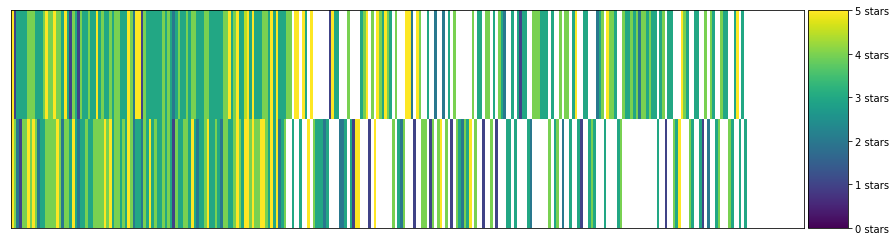

In [ ]:
# Picking a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
# Sort and print the cluster
cluster = get_most_rated_movies(cluster, n_movies)
draw_movies_heatmap(cluster, axis_labels=False)

In [ ]:
# Print the ratings
cluster.fillna('').head()

,Terminator 3: Rise of the Machines,The Third Man,Kolja,The Fountain,"Nosferatu, eine Symphonie des Grauens",Houseboat,Saw,Dogtown and Z-Boys,Ghost Rider,Killing Zoe,Sweet Sixteen,Mr. Bean's Holiday,Rambo III,The Grapes of Wrath,The Thirteenth Floor,The Magnificent Ambersons,Nostalghia,The Million Dollar Hotel,The Terminal,Lolita,Madagascar,Rocky IV,Le Mépris,Notting Hill,Stand by Me,Out of Sight,Bride of Frankenstein,The Simpsons Movie,Monsieur Ibrahim et les fleurs du Coran,The Poseidon Adventure,La science des rêves,The War of the Roses,Because I Said So,Rocky Balboa,Le fabuleux destin d'Amélie Poulain,Sunshine,300,The Killing,To Be or Not to Be,Escape from New York,...,The Day After Tomorrow,Muriel's Wedding,Breaking the Waves,The Living Daylights,座頭市,Donnie Darko,The Green Mile,The Sixth Sense,The Thomas Crown Affair,Aliens vs Predator: Requiem,Cutthroat Island,Ocean's Eleven,The Last Samurai,Armageddon,Dancer in the Dark,2001: A Space Odyssey,The Good Shepherd,Ocean's Twelve,The Searchers,Chinatown,54,Angel Heart,Bill & Ted's Bogus Journey,Freedom Writers,Batman,Exodus,Transformers,Ночной дозор,A Hard Day's Night,Z,Fame,Gattaca,Bird on a Wire,Lost Horizon,Batman Forever,Down by Law,Tillsammans,Backdraft,Tropa de Elite,The First Wives Club
0,5.0,1.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,3.0,5.0,3.0,1.0,4.0,3.0,1.0,4.0,3.0,3.0,4.0,3.0,3.0,5.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,...,,,4,,4,3,,,4,3,3,,,3,5,,3,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,2.0,1.0,4.0,4.0,5.0,4.0,5.0,4.0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,5.0,4.0,2.0,4.0,4.0,3.0,5.0,3.0,2.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,4.0,...,3,1,,2,,,3,4,,,,4,3,,,3,,3,,,,,,,,,,,,,,,,,,,,,,


***PREDICTING RATING USING CLUSTERING***

In [ ]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Terminator 3: Rise of the Machines       5.0
The Third Man                            2.5
Kolja                                    2.5
The Fountain                             2.0
Nosferatu, eine Symphonie des Grauens    3.5
Houseboat                                3.5
Saw                                      4.5
Dogtown and Z-Boys                       4.0
Ghost Rider                              4.5
Killing Zoe                              3.5
Sweet Sixteen                            2.5
Mr. Bean's Holiday                       3.0
Rambo III                                3.5
The Grapes of Wrath                      4.5
The Thirteenth Floor                     4.0
The Magnificent Ambersons                4.0
Nostalghia                               4.5
The Million Dollar Hotel                 4.5
The Terminal                             4.0
Lolita                                   2.5
dtype: float64

***RECOMMENDATION USING CLUSTERING (KNN)***

In [ ]:
# Pick a user ID from the dataset
user_id = 6
# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate? 
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

**END OF MOVIE RECOMMENDATION USING CLUSTERING ALGORITHM (KNN) **

## **VISUALIZATION OF THE DATASET**

In [ ]:
movies_links['popularity'] = movies_links['popularity'].astype('float')

Text(0.5, 1.0, 'Popular Movies')

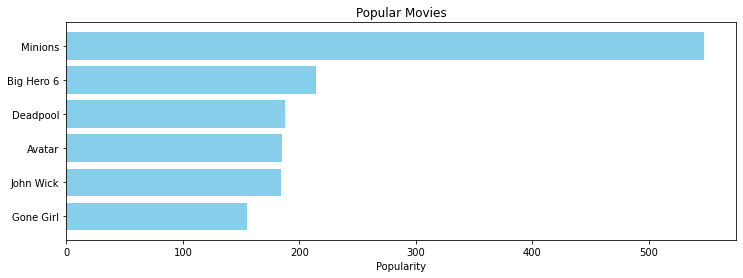

In [ ]:
pop= movies_links.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

In [ ]:
s = movies.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = movies.drop('genres', axis=1).join(s)

In [ ]:
md_year = pd.DataFrame(gen_md.groupby('release_date').original_title.nunique())
md_year.head()

,original_title
release_date,
1874-12-09,1
1878-06-14,1
1883-11-19,1
1887-08-18,1
1888-01-01,1


In [ ]:
md_year.nlargest(5,'original_title')

,original_title
release_date,
2008-01-01,136
2009-01-01,121
2007-01-01,117
2005-01-01,111
2006-01-01,101


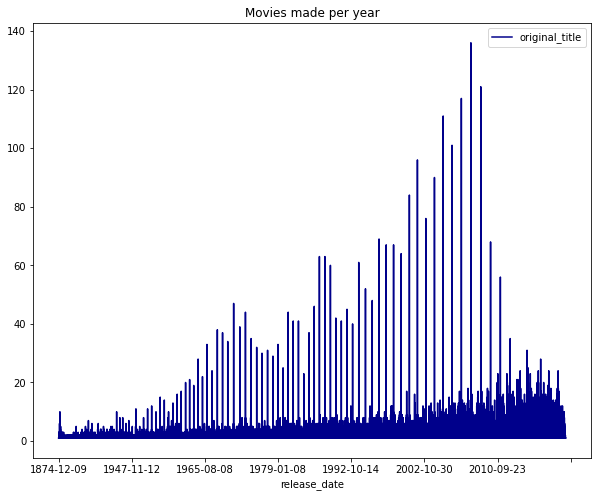

In [ ]:
md_year.plot.line(title = 'Movies made per year',color='DarkBlue',figsize=(10, 8));

In [ ]:
md_genre = (pd.DataFrame(gen_md.groupby('genre').original_title.nunique())).sort_values('original_title', ascending=True)
md_genre.head(20)

,original_title
genre,
TV Movie,764
Western,1021
War,1308
History,1374
Music,1567
Foreign,1615
Animation,1919
Fantasy,2219
Mystery,2405


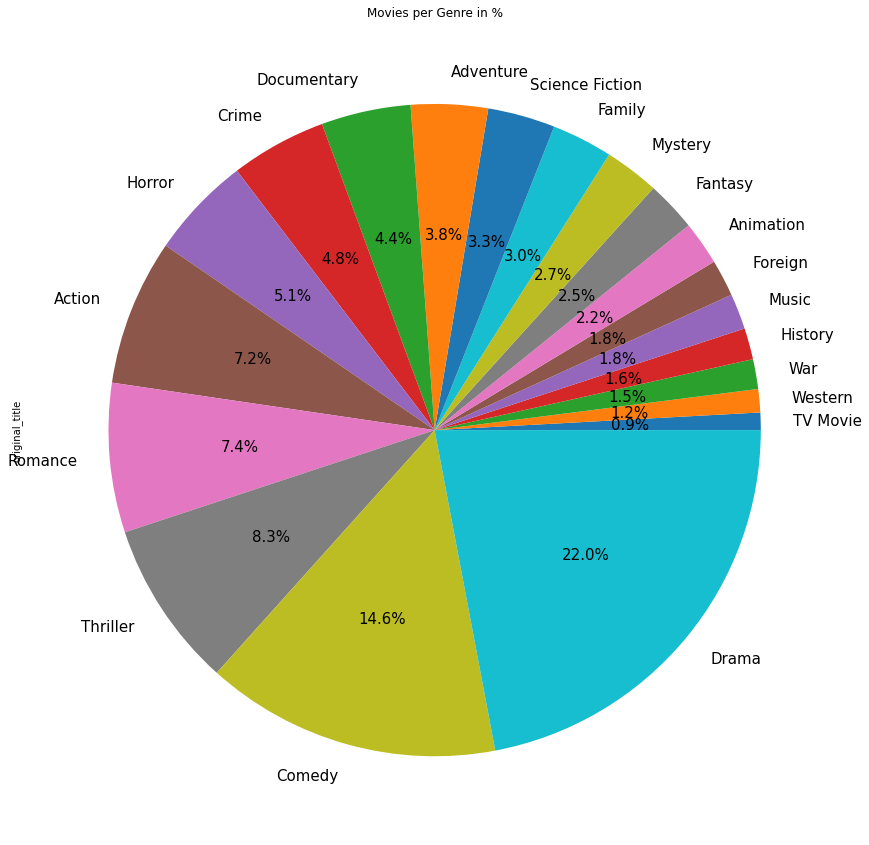

In [ ]:
md_genre['original_title'].plot.pie(title= 'Movies per Genre in %', figsize=(15,15), autopct='%1.1f%%',fontsize=15);

In [ ]:
md_year_mean = gen_md.groupby('release_date').mean()
md_year_mean.head(3)

,id,revenue,runtime,vote_average,vote_count
release_date,,,,,
1874-12-09,315946.0,0.0,1.0,6.0,19.0
1878-06-14,194079.0,0.0,1.0,6.2,25.0
1883-11-19,426903.0,0.0,1.0,5.4,7.0


In [ ]:
md_year_mean.nlargest(5,'vote_count')

,id,revenue,runtime,vote_average,vote_count
release_date,,,,,
2015-04-22,99861.000000,1.405404e+09,141.000000,7.30,6908.000000
2016-02-09,329346.000000,4.698678e+08,104.000000,5.76,6867.800000
2015-05-13,161684.166667,2.525766e+08,116.333333,7.30,6445.666667
2008-06-22,10681.000000,5.213119e+08,98.000000,7.80,6439.000000
2012-11-26,70785.750000,7.658277e+08,149.250000,6.85,6324.000000


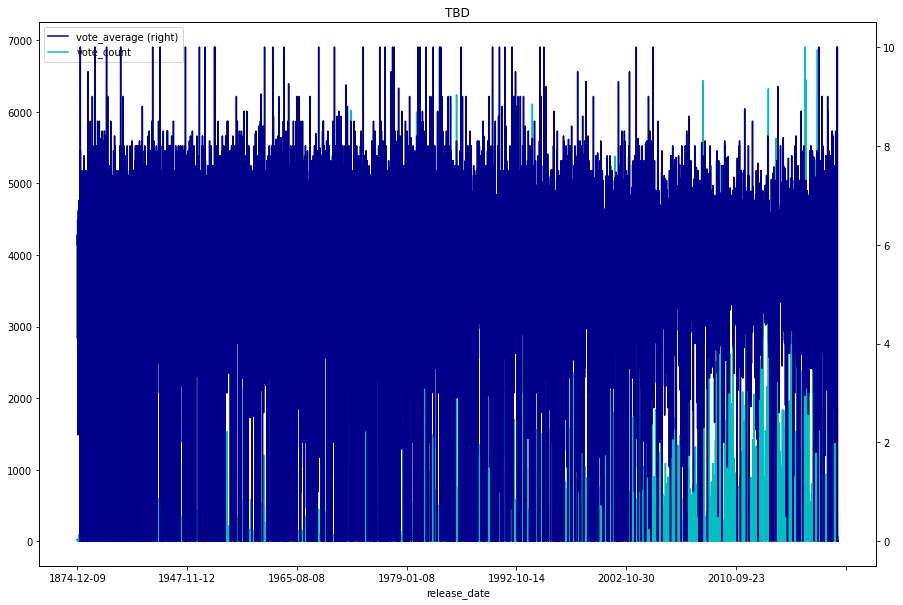

In [ ]:
md_year_mean[['vote_average', 'vote_count']].plot(title = 'TBD',color=('DarkBlue','c'),figsize=(15, 10),secondary_y=['vote_average']);

In [ ]:
movies.corr(method='pearson')

,id,revenue,runtime,vote_average,vote_count
id,1.000000,-0.071263,-0.121399,-0.167573,-0.064903
revenue,-0.071263,1.000000,0.103917,0.083868,0.812022
runtime,-0.121399,0.103917,1.000000,0.158146,0.113539
vote_average,-0.167573,0.083868,0.158146,1.000000,0.123607
vote_count,-0.064903,0.812022,0.113539,0.123607,1.000000


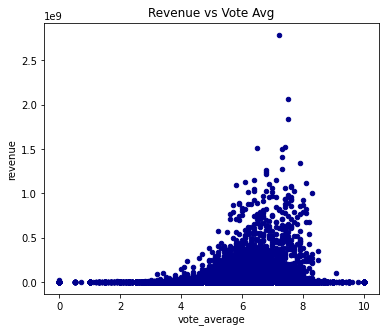

In [ ]:
movies.plot.scatter(x='vote_average', y='revenue',title='Revenue vs Vote Avg',color='DarkBlue',figsize=(6,5));

### **CONTENT RECOMMENDER 1**

In [ ]:
movies_links.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,movieId
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,862
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,8844
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,15602
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,31357
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,11862


In [ ]:
movies_links['tagline'] = movies_links['tagline'].fillna('')
movies_links['description'] = movies_links['overview'] + movies_links['tagline']
movies_links['description'] = movies_links['description'].fillna('')

In [ ]:
movies_links['description']

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
40224    From the mind behind Evangelion comes a hit la...
40503    The band stormed Europe in 1963, and, in 1964,...
44821    When Molly Hale's sadness of her father's disa...
44826    All your favorite Pokémon characters are back,...
45265    While holidaying in the French Alps, a Swedish...
Name: description, Length: 9099, dtype: object

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_links['description'])

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)

In [ ]:
cosine_sim

array([[1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
        0.        ],
       [0.00680476, 1.        , 0.01531062, ..., 0.00357057, 0.00762326,
        0.        ],
       [0.        , 0.01531062, 1.        , ..., 0.        , 0.00286535,
        0.00472155],
       ...,
       [0.        , 0.00357057, 0.        , ..., 1.        , 0.07811616,
        0.        ],
       [0.00344913, 0.00762326, 0.00286535, ..., 0.07811616, 1.        ,
        0.        ],
       [0.        , 0.        , 0.00472155, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
movies_links.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,movieId,description
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,862,"Led by Woody, Andy's toys live happily in his ..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,8844,When siblings Judy and Peter discover an encha...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,15602,A family wedding reignites the ancient feud be...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,31357,"Cheated on, mistreated and stepped on, the wom..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,11862,Just when George Banks has recovered from his ...


In [ ]:
movies_links = movies_links.reset_index()
titles = movies_links['title']
indices = pd.Series(movies_links.index, index=movies_links['title'])

In [ ]:
titles

0                                               Toy Story
1                                                 Jumanji
2                                        Grumpier Old Men
3                                       Waiting to Exhale
4                             Father of the Bride Part II
                              ...                        
9094                                        Shin Godzilla
9095    The Beatles: Eight Days a Week - The Touring Y...
9096                        Pokémon: Spell of the Unknown
9097          Pokémon 4Ever: Celebi - Voice of the Forest
9098                                        Force Majeure
Name: title, Length: 9099, dtype: object

In [ ]:
def content_recommendations1(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores,key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
content_recommendations1('Summer of Sam').head(10)

6126                 Kicking & Screaming
7237                 Breakfast with Scot
7042                           Max Payne
3881                            I Am Sam
7817    Burn Notice: The Fall of Sam Axe
7642            1990: The Bronx Warriors
317                             Crooklyn
8378                                Koch
7374                            Brothers
4210                       The Wanderers
Name: title, dtype: object

In [ ]:
content_recommendations1('Batman: Under the Red Hood').head(10)

1113                             Batman Returns
7931                      The Dark Knight Rises
2579               Batman: Mask of the Phantasm
8227    Batman: The Dark Knight Returns, Part 2
524                                      Batman
8165    Batman: The Dark Knight Returns, Part 1
6144                              Batman Begins
6900                            The Dark Knight
8917         Batman v Superman: Dawn of Justice
466                   Robin Hood: Men in Tights
Name: title, dtype: object

### ***CONTENT RECOMMENDER 2***

In [ ]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies['id'] = movies['id'].astype('int')

In [ ]:
movies.shape

(45463, 25)

In [ ]:
movies = movies.merge(credits, on='id')
movies = movies.merge(keywords, on='id')

In [ ]:
movies_links = movies[movies['id'].isin(links_small)]
movies_links.shape

(9219, 28)

In [ ]:
movies_links['cast'] = movies_links['cast'].apply(literal_eval)
movies_links['crew'] = movies_links['crew'].apply(literal_eval)
movies_links['keywords'] = movies_links['keywords'].apply(literal_eval)
movies_links['cast_size'] = movies_links['cast'].apply(lambda x: len(x))
movies_links['crew_size'] = movies_links['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
movies_links['director'] = movies_links['crew'].apply(get_director)

In [ ]:
movies_links['cast'] = movies_links['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_links['cast'] = movies_links['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [ ]:
movies_links['keywords'] = movies_links['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
movies_links['cast'] = movies_links['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
movies_links['director'] = movies_links['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
movies_links['director'] = movies_links['director'].apply(lambda x: [x,x, x])

In [ ]:
movies_links.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,"[johnlasseter, johnlasseter, johnlasseter]"


In [ ]:
s = movies_links.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
sd = pd.DataFrame(s)

In [ ]:
sd.head(10)

,keyword
independent film,610
woman director,550
murder,399
duringcreditsstinger,327
based on novel,318
violence,264
love,222
sex,219
musical,219
suspense,212


In [ ]:
s = s[s > 1]

In [ ]:
lemman = WordNetLemmatizer()

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
movies_links['keywords'] = movies_links['keywords'].apply(filter_keywords)
movies_links['keywords'] = movies_links['keywords'].apply(lambda x: [lemman.lemmatize(i) for i in x])
movies_links['keywords'] = movies_links['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
movies_links['combo'] = movies_links['keywords'] + movies_links['cast'] + movies_links['director'] + movies_links['genres']
movies_links['combo'] = movies_links['combo'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
bow = count.fit_transform(movies_links['combo'])

In [ ]:
cosine_sim = cosine_similarity(bow)

In [ ]:
movies_links = movies_links.reset_index()
titles = movies_links['title']
indices = pd.Series(movies_links.index, index=movies_links['title'])

In [ ]:
def content_recommendations2(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movie = movies_links.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movie[movie['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movie[movie['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    def weighted_rating(x):
        v = x['vote_count']
        R = x['vote_average']
        return (v/(v+m) * R) + (m/(m+v) * C)
    qualified = movie[(movie['vote_count'] >= m) & (movie['vote_count'].notnull()) & (movie['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
content_recommendations2('Inception')

,title,vote_count,vote_average,year,wr
6981,The Dark Knight,12269,8,2008,7.712595
8613,Interstellar,11187,8,2014,7.689206
6623,The Prestige,4510,8,2006,7.375650
3381,Memento,4168,8,2000,7.341628
8031,The Dark Knight Rises,9263,7,2012,6.822018
6218,Batman Begins,7511,7,2005,6.789601
4173,Minority Report,2663,7,2002,6.575815
7286,X-Men Origins: Wolverine,4086,6,2009,6.013614
8207,Looper,4777,6,2012,6.012248
7903,Green Lantern,2551,5,2011,5.470580


In [ ]:
content_recommendations2('Mean Girls')

,title,vote_count,vote_average,year,wr
1547,The Breakfast Club,2189,7,1985,6.753897
390,Dazed and Confused,588,7,1993,6.369346
8883,The DUFF,1372,6,2015,5.884127
3712,The Princess Diaries,1063,6,2001,5.860251
4763,Freaky Friday,919,6,2003,5.845406
6277,Just Like Heaven,595,6,2005,5.796851
6959,The Spiderwick Chronicles,593,6,2008,5.796457
7494,American Pie Presents: The Book of Love,454,5,2009,5.254920
7332,Ghosts of Girlfriends Past,716,5,2009,5.196974
7905,Mr. Popper's Penguins,775,5,2011,5.187382


### ***COLABORATIVE FILTERING***

In [ ]:
reader = Reader()

In [ ]:
ratings = pd.read_csv('ratings_small.csv')
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [ ]:
gb = ratings.groupby(['userId','movieId'])
gb.apply(lambda _df: _df.sort_values(by=['rating']))

userId  movieId  rating   timestamp
userId movieId                                            
1      31      0            1       31     2.5  1260759144
       1029    1            1     1029     3.0  1260759179
       1061    2            1     1061     3.0  1260759182
       1129    3            1     1129     2.0  1260759185
       1172    4            1     1172     4.0  1260759205
...                       ...      ...     ...         ...
671    6268    99999      671     6268     2.5  1065579370
       6269    100000     671     6269     4.0  1065149201
       6365    100001     671     6365     4.0  1070940363
       6385    100002     671     6385     2.5  1070979663
       6565    100003     671     6565     3.5  1074784724

[100004 rows x 4 columns]

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

***CROSS-VALIDATION***

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=10, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9072  0.8907  0.8885  0.8956  0.8955  0.8893  0.8872  0.8966  0.8919  0.8935  0.8936  0.0055  
MAE (testset)     0.6959  0.6868  0.6841  0.6862  0.6889  0.6863  0.6833  0.6888  0.6863  0.6858  0.6872  0.0033  
Fit time          5.48    5.51    5.51    5.46    5.49    5.46    5.49    5.48    5.46    5.47    5.48    0.02    
Test time         0.07    0.07    0.07    0.07    0.07    0.07    0.07    0.07    0.07    0.07    0.07    0.00    
Evaluating RMSE, MAE of algorithm SlopeOne on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9269  0.9203  0.9150  0.9235  0.9175  0.9294  0.9376  0.9327  0.9125  0.9172  0.9233  0.0078  
MAE (testset)     0.7123  0.7019  0.7000  0.7106  0.7011  0.7070  0.7181  0.7185

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.893610,0.687234,5.480032,0.068216
KNNWithZScore,0.912310,0.694505,0.235163,1.037082
KNNWithMeans,0.913354,0.699025,0.186262,0.959879
SlopeOne,0.923276,0.706530,4.896817,3.497434
NMF,0.937811,0.720154,6.135920,0.059116
CoClustering,0.957483,0.743046,2.439011,0.051701
KNNBasic,0.961335,0.738303,0.159101,0.911532
NormalPredictor,1.434612,1.145109,0.144906,0.074340


In [ ]:
bench=pd.DataFrame(benchmark).sort_values('test_rmse')

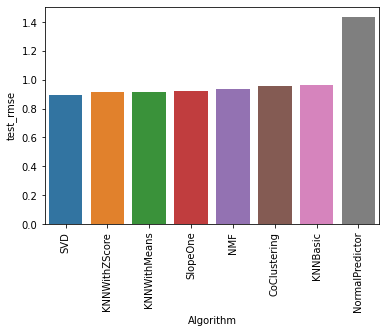

In [ ]:
sns.barplot(x='Algorithm',y='test_rmse',data=bench,label="Number of Words")
plt.xticks(rotation=90)
plt.show()

In [ ]:
trainset = data.build_full_trainset()

svd = SVD()
svd.fit(trainset)

In [ ]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.7119621393365247, details={'was_impossible': False})

### ***HYBRID***

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(movies_links[['title', 'id']], on='id').set_index('title')

In [ ]:
indices_map = id_map.set_index('id')

***HYBRID FUNCTION***

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = movies_links.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
1011,The Terminator,4208.0,7.4,1984,218,3.168944
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.074485
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,2.984640
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.981619
922,The Abyss,822.0,7.1,1989,2756,2.868801
3181,The Time Machine,217.0,7.5,1960,2134,2.851862
3060,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,2.811189
1668,Return from Witch Mountain,38.0,5.6,1978,14822,2.799437
344,True Lies,1138.0,6.8,1994,36955,2.799266
4017,Hawk the Slayer,13.0,4.5,1980,25628,2.769174


In [ ]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
1376,Titanic,7770.0,7.5,1997,597,3.281204
6084,Beastmaster 2: Through the Portal of Time,17.0,4.6,1991,27549,3.208273
2132,Superman II,642.0,6.5,1980,8536,3.201654
3060,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,3.177039
344,True Lies,1138.0,6.8,1994,36955,3.170682
1668,Return from Witch Mountain,38.0,5.6,1978,14822,3.107994
922,The Abyss,822.0,7.1,1989,2756,3.099814
3181,The Time Machine,217.0,7.5,1960,2134,3.082511
831,Escape to Witch Mountain,60.0,6.5,1975,14821,3.027656
4347,Piranha Part Two: The Spawning,41.0,3.9,1981,31646,3.024012


In [ ]:
hybrid(500, 'Aliens')

,title,vote_count,vote_average,year,id,est
1376,Titanic,7770.0,7.5,1997,597,3.281204
6640,Déjà Vu,1519.0,6.6,2006,7551,3.230441
7939,Gantz,73.0,6.5,2011,56832,3.217146
344,True Lies,1138.0,6.8,1994,36955,3.170682
922,The Abyss,822.0,7.1,1989,2756,3.099814
8468,Riddick,2066.0,6.2,2013,87421,3.091401
987,Alien,4564.0,7.9,1979,348,3.083855
7498,Daybreakers,646.0,6.0,2009,19901,3.078114
3935,Impostor,136.0,6.1,2001,4965,3.063247
4347,Piranha Part Two: The Spawning,41.0,3.9,1981,31646,3.024012


In [ ]:
hybrid(1, 'Aliens')

,title,vote_count,vote_average,year,id,est
1011,The Terminator,4208.0,7.4,1984,218,3.168944
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,2.984640
6640,Déjà Vu,1519.0,6.6,2006,7551,2.916540
7488,Avatar,12114.0,7.2,2009,19995,2.882087
922,The Abyss,822.0,7.1,1989,2756,2.868801
7498,Daybreakers,646.0,6.0,2009,19901,2.825291
344,True Lies,1138.0,6.8,1994,36955,2.799266
7939,Gantz,73.0,6.5,2011,56832,2.787016
987,Alien,4564.0,7.9,1979,348,2.783709
7828,I Am Number Four,1606.0,5.9,2011,46529,2.715213


## ***EVALUATION - HIT RATE***

***INITIALIZING LEAVEONEOUT FUNCTION***

In [ ]:
LOOCV = LeaveOneOut(n_splits=1, random_state=1)

***DEFINING A FUNCTION TO GET THE TOP TEN PREDICTIONS FOR ALL USERS***

In [ ]:
def GetTop10(all_predictions, n=10, minimumRating=4.0):
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in all_predictions:
        if (estimatedRating >= minimumRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]

    return topN

***SPLITTING THE DATA INTO TEST AND TRAIN SET FOR EFFECTIVE EVALUATION***

In [ ]:
for trainSet, testSet in LOOCV.split(data):
    # Train model without left-out ratings
    svd.fit(trainSet)
    # Predicts ratings for left-out ratings only
    leftOutPredictions = svd.test(testSet)
    # Build predictions for all ratings not in the training set
    bigTestSet = trainSet.build_anti_testset()
    allPredictions = svd.test(bigTestSet)

***SHOWING THE TOP 10 RATINGS FOR ALL USERS***

In [ ]:
top10Predicted = GetTop10(allPredictions, n=10)
top10Predicted

defaultdict(list,
            {2: [(318, 4.574039674504217),
              (858, 4.570650208408749),
              (1207, 4.491464171234429),
              (953, 4.482900666791958),
              (1276, 4.462374516677613),
              (969, 4.455222875326895),
              (7502, 4.435521386719106),
              (4993, 4.433858063244167),
              (1225, 4.40499424686369),
              (3462, 4.394666861959811)],
             3: [(926, 4.383932263120283),
              (922, 4.298119464898653),
              (969, 4.29636881015175),
              (2289, 4.2884495490640795),
              (908, 4.272758944579587),
              (741, 4.267155961719367),
              (3504, 4.2521050331388945),
              (6016, 4.246562178156505),
              (858, 4.240066617364173),
              (7502, 4.23979019028619)],
             4: [(1172, 5),
              (47, 5),
              (50, 5),
              (527, 5),
              (318, 5),
              (1221, 5),
              (120

***FUNCTION TO GET THE HIT RATE***

In [ ]:
def HitRate(predictions, leftOutPredictions):
    hits = 0
    total = 0

 # For each left-out rating
    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutMovieID = leftOut[1]
        # Is it in the predicted top 10 for this user?
        hit = False
        for movieID, predictedRating in predictions[int(userID)]:
            if (int(leftOutMovieID) == int(movieID)):
                hit = True
                break
        if (hit) :
            hits += 1

        total += 1

    # Compute overall precision
    return hits/total


In [ ]:
Hitrate = HitRate(top10Predicted, leftOutPredictions)
Hitrate

0.019374068554396422